In [75]:
!pip3 install numpy scikit-learn pandas scipy pyinform seaborn xgboost matplotlib imbalanced-learn

     -------------------------------------- 225.4/225.4 kB 4.6 MB/s eta 0:00:00


In [93]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay, precision_recall_fscore_support
from imblearn.metrics import geometric_mean_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pyinform
import pandas as pd
from os import listdir
from scipy import stats
import math

The different stages of our classification framework. (notes from paper)
1. First, we use light curves of variable stars as input data. For the first stage process, features are extracted using FATS and then are later split into training and test sets. 
2. The second stage involves data pre-processing and feature selection. In this process, the extracted features are normalized, visualized, and selected based on various techniques. 
3. Afterwards, the third stage covers hyperparameter optimization using the randomized grid search with cross-validation methods.
4. Finally, the last stage uses the best hyperparameter to re-train the ML algorithms using the entire normalized training set in stage 2 and evaluate it on the normalized test set in stage 2 using various metrics to quantify the models.


Types: 1=RRab,2=RRc,3=RRd,4=Blazkho,5=Eclipsing Binary, 6=EA, 7=Rotational Var,
8=LPV,9=delta-Scuti,10=ACep,11=Misc,12=Cep-II,13=LMC Classical Cep


2. Format data, remove ~14.5k of y=5 (variable star type)

In [8]:
raw_data = None
with open('SSS_Per_Tab.dat', 'r') as data:
    temp = []
    temp.append(data.readline().split())
    for line in data: 
        if len(line.split()) >= 11:
            temp1 = line.split()
            temp1[5] = float(temp1[5])
            temp1[9] = ' '.join(temp1[9:])
            temp.append(temp1[:10])
        else:
            temp1 = line.split()
            temp1[5] = float(temp1[5])
            temp.append(temp1)

raw_data = pd.DataFrame(temp[1:], columns=temp[0])
leftOutT5 = raw_data[raw_data.Type.eq('5')].sample(14294, random_state=1).index
data = raw_data.drop(leftOutT5)
leftOutT5 = raw_data.iloc[leftOutT5]
data = data.drop(data[data.Type.eq('11')].index)
data = data.drop(data[data.Type.eq('13')].index)
data = data[((data['V_CSS'] - data['V_CSS'].mean()) / data['V_CSS'].std()).abs() < 3]

Now the data is balanced

3. transform data to get the 7 predictors: location (mean magnitude), scale (standard deviation), 
variability (mean variance), morphology (skew, kurtosis, and amplitude), and time (period)
4. make new df with features
5. create labelled input vector {(X_1, y_1),...,(X_n,y_n)} where X_i is an individual star and y_i is a label (type of variable star) 

In [9]:
#get the unfolded time-series data in SSS_Per_Var_Cat
transformed = pd.DataFrame(columns=['Id', "type", 'mean', 'std', 'mean variance', 'skew', 'kurtosis', 'amplitude', 'period'])
for fname in listdir('./SSS_Per_Var_Cat/'):
    fnum = fname.split('.')[0]
    if fnum in data['Numerical_ID'].values:
        with open('SSS_Per_Var_Cat/'+fname, 'r') as file:
            lines = file.readlines()
            mag = [float(line.split()[1]) for line in lines]
            n = len(mag)
            mean = np.mean(mag)
            std = np.std(mag)
            meanVar = std/mean
            skew = stats.skew(mag)
            S = sum(((mag - mean) / std) ** 4)
            c1 = float(n * (n + 1)) / ((n - 1) * (n - 2) * (n - 3))
            c2 = float(3 * (n - 1) ** 2) / ((n - 2) * (n - 3))
            kurtosis = c1 * S - c2
            sorted_mag = np.sort(mag)
            amplitude = (np.median(sorted_mag[-math.ceil(0.05 * n):]) -
                np.median(sorted_mag[0:math.ceil(0.05 * n)])) / 2.0
            period = data.loc[data.query(f'Numerical_ID == "{fnum}"').index[0], 'Period']
            label = data.loc[data.query(f'Numerical_ID == "{fnum}"').index[0], 'Type']
            transformed.loc[len(transformed.index)] = [float(fnum), label, float(mean), float(std), float(meanVar), float(skew), float(kurtosis), float(amplitude), float(period)] #all features per star


6. split into training and test data then normalize the data

In [10]:
train = transformed.sample(frac=0.7, random_state=1)
test = transformed.drop(train.index)
maxLo, maxSc = train['mean'].abs().max(), train['std'].abs().max()
maxV, maxSk = train['mean variance'].abs().max(), train['skew'].abs().max()
maxK, maxA, maxP = train['kurtosis'].abs().max(), train['amplitude'].abs().max(), train['period'].abs().max()

In [11]:
def normalize(x, maxVal):
    return abs(x/maxVal)
train['mean'] = train['mean'].apply(normalize, args=(maxLo,))
train['std'] = train['std'].apply(normalize, args=(maxSc,))
train['mean variance'] = train['mean variance'].apply(normalize, args=(maxV,))
train['skew'] = train['skew'].apply(normalize, args=(maxSk,))
train['kurtosis'] = train['kurtosis'].apply(normalize, args=(maxK,))
train['amplitude'] = train['amplitude'].apply(normalize, args=(maxA,))
train['period'] = train['period'].apply(normalize, args=(maxP,))

test['mean'] = test['mean'].apply(normalize, args=(maxLo,))
test['std'] = test['std'].apply(normalize, args=(maxSc,))
test['mean variance'] = test['mean variance'].apply(normalize, args=(maxV,))
test['skew'] = test['skew'].apply(normalize, args=(maxSk,))
test['kurtosis'] = test['kurtosis'].apply(normalize, args=(maxK,))
test['amplitude'] = test['amplitude'].apply(normalize, args=(maxA,))
test['period'] = test['period'].apply(normalize, args=(maxP,))

7. Visualization

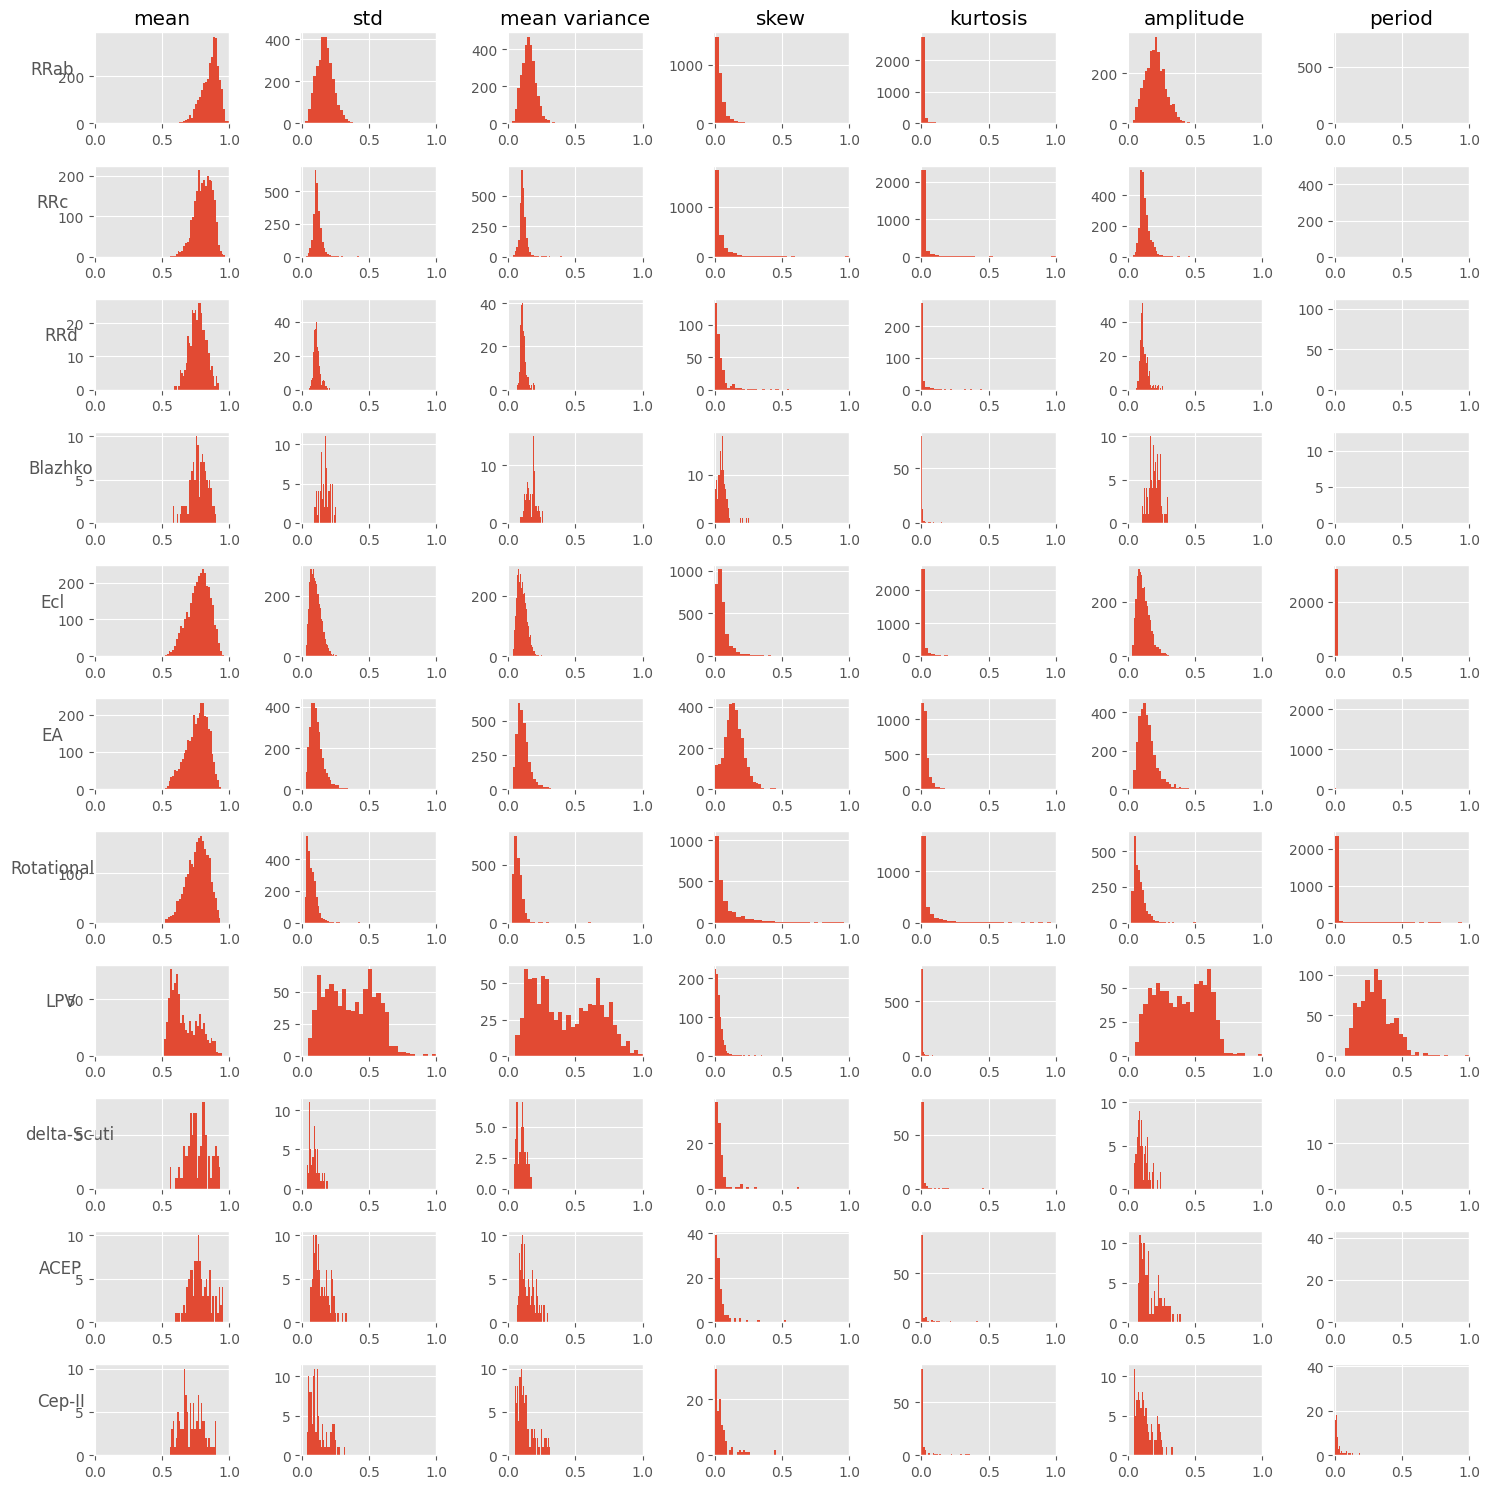

In [12]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=11, ncols=7, figsize=(15,15))
types = {
    '1':'RRab','2':'RRc','3':"RRd",'4':"Blazhko",'5':'Ecl','6':'EA','7':"Rotational",'8':'LPV','9':"delta-Scuti",'10':"ACEP",'12':"Cep-II"
}
rows = [str(row) for row in types.values()]
cols = [str(col) for col in train.columns[2:]]
for a, col in zip(ax[0], cols):
    a.set_title(col)

for a, row in zip(ax[:,0], rows):
    a.set_ylabel(row, rotation=0, size='large')
# Iterate through each column

for i, col in enumerate(train.columns[2:]):
    # Iterate through each type
    for j, t in enumerate(['1','2','3','4','5','6','7','8','9','10','12']):
        
        # Filter the dataframe for the current type
        df_type = train[train['type'] == t]
        
        # Plot the density of the column
        ax[j,i].hist(df_type[col],bins=30)
        ax[j,i].set_xlim([-0.01,1])
# plt.xlim(0,1)
fig.tight_layout() 
# Show the plot
plt.show()

Set up data, for different plots

In [13]:
largeTrain = train.query('type in ["1","2","5","6","7","8"]')
smallTrain = train.query('type not in ["1","2","5","6","7","8"]')

lTrainX, sTrainX = largeTrain.query('type in ["1","6","7","8"]'), smallTrain.query("type != '3'")
lTrainX = largeTrain.query('type not in ["2", "5"]').drop(['type', 'Id'], axis=1)
lTrainY = largeTrain.query('type not in ["2", "5"]').loc[:, 'type'].apply(lambda x: int(x))
sTrainX  = smallTrain.query('type != "3"').drop(['type', 'Id'], axis=1)
sTrainY = smallTrain.query('type != "3"').loc[:, 'type'].apply(lambda x: int(x))

Visualize large sample and small sample data using t-SNE

In [14]:
tsne = TSNE(2, random_state=1, n_iter=1500, n_jobs=5)
resL = tsne.fit_transform(lTrainX)
resS = tsne.fit_transform(sTrainX)


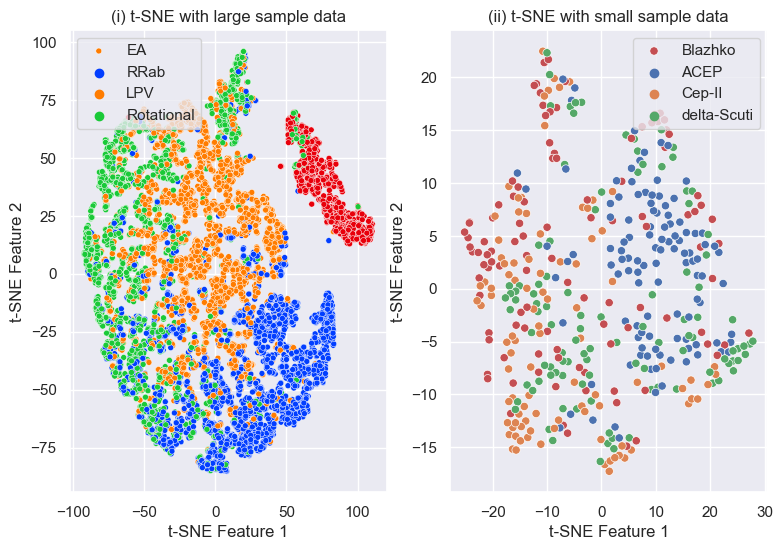

In [15]:
sns.set(rc={'figure.figsize':(9,6)})
fig, ax = plt.subplots(1, 2)

# Plot the first scatterplot in the first subplot
sns.scatterplot(x=resL[:,0], y=resL[:,1], hue=lTrainY, legend='auto', palette=sns.color_palette("bright", 4), ax=ax[0], size=2)
ax[0].legend(['EA', "RRab", "LPV", 'Rotational' ] , loc="upper left")
ax[0].set_xlabel("t-SNE Feature 1")
ax[0].set_ylabel("t-SNE Feature 2")
ax[0].set_title("(i) t-SNE with large sample data")
# Plot the second scatterplot in the second subplot
sns.scatterplot(x=resS[:,0], y=resS[:,1], hue=sTrainY, legend='full', palette=sns.color_palette("deep", 4), ax=ax[1])
ax[1].set_xlabel("t-SNE Feature 1")
ax[1].set_ylabel("t-SNE Feature 2")
ax[1].set_title("(ii) t-SNE with small sample data")
ax[1].legend(['Blazhko', 'ACEP', 'Cep-II', 'delta-Scuti'] , loc="upper right")

plt.show()

The red portion of stars separated are LPV, the legend label is too orange.

Hyperparameter tuning and Optimization

In [120]:
skf = StratifiedKFold(n_splits=5)

rf_clf = RandomForestClassifier(random_state=1)
rf_param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 3000, num = 19)],
    'max_depth': [5, 10, 15, 20, 25, 35, 50, 60 ,75, 90, 110, None],
    'min_samples_split': [2, 5, 10, 15,17,20,25, 30],
    'min_samples_leaf': [1, 2, 5, 7, 10, 15],
    'max_features': ['sqrt', 'log2',3,4,6,7],
    'criterion':['gini', 'entropy', 'log_loss']
}

knn_clf = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 20, 25],
    'weights': ['uniform', 'distance'],
    'algorithm':['kd_tree','auto'],
    'p': [1,2,5]
}

dt_clf = DecisionTreeClassifier(random_state=1)
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, 25, None],
    'criterion':['gini', 'entropy'],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'splitter' : ['best', 'random']
}

xTrain, yTrain = train.drop(['type', 'Id'], axis=1), train['type']
xTest, yTest = test.drop(['type', 'Id'], axis=1), test['type']
yTrain = yTrain.astype(int).map(lambda x: 0 if x == 12 else x)
yTest = yTest.astype(int).map(lambda x: 0 if x == 12 else x)

In [ ]:
rsRF = RandomizedSearchCV(rf_clf, rf_param_grid, scoring="balanced_accuracy", cv=skf, n_jobs=-1, n_iter=37, random_state=1)
rsRF.fit(xTrain, yTrain)
rfHyper = rsRF.best_params_
print(f'Best hyperparameters for RandomForestClassifier: {rsRF.best_params_}')

In [118]:
rsK= RandomizedSearchCV(knn_clf, knn_param_grid, n_iter=40, scoring="balanced_accuracy", cv=skf, random_state=1)
rsK.fit(xTrain, yTrain)
knnHyper = rsK.best_params_
print(f'Best hyperparameters for KNeighborsClassifier: {rsK.best_params_}')

rsDt = RandomizedSearchCV(dt_clf, dt_param_grid, n_iter=40, scoring="balanced_accuracy", cv=skf, random_state=1)
rsDt.fit(xTrain, yTrain)
dtHyper = rsDt.best_params_
print(f'Best hyperparameters for DecisionTreeClassifier: {rsDt.best_params_}')

Best hyperparameters for KNeighborsClassifier: {'weights': 'distance', 'p': 2, 'n_neighbors': 15, 'algorithm': 'kd_tree'}
Best hyperparameters for DecisionTreeClassifier: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}


Performance of multiclass classification

In [145]:
#change these to optimal hyper params
rf_clf = RandomForestClassifier(990, min_samples_split= 2, min_samples_leaf=1, max_features='sqrt', max_depth=90, criterion='entropy', random_state=1)
# rf_clf = XGBClassifier(random_state=1, tree_method='gpu_hist', objective='binary:logistic',n_estimators=750, learning_rate=0.05, 
#                         eval_metric = "rmse", colsample_bytree=0.8, min_child_weight=5, gamma=1)
knn_clf = KNeighborsClassifier(weights ='distance', p=2, n_neighbors=15, algorithm='kd_tree')
dt_clf = DecisionTreeClassifier(splitter='best', min_samples_split= 10, min_samples_leaf=1, max_features='log2', criterion='entropy', random_state=1)

fitDT = dt_clf.fit(xTrain, yTrain)
fitRF = rf_clf.fit(xTrain, yTrain)
fitKNN = knn_clf.fit(xTrain, yTrain)
classNames = ["RRab",'RRc',"RRd",'Blazkho',"Ecl", "EA", "Rotational","LPV",'delta-Scuti',"ACEP",'Cep-II']


In [146]:

rf_pred = fitRF.predict(xTest)
knn_pred = fitKNN.predict(xTest)
dt_pred = fitDT.predict(xTest)

rf_acc = balanced_accuracy_score(yTest, rf_pred)
knn_acc = balanced_accuracy_score(yTest, knn_pred)
df_acc = balanced_accuracy_score(yTest, dt_pred)

print(f"Balanced accuracy of random forest: {rf_acc}")
print(f"Balanced accuracy of k-nearest neighbors: {knn_acc}")
print(f"Balanced accuracy of decision tree: {df_acc}")

Balanced accuracy of random forest: 0.567368027994042
Balanced accuracy of k-nearest neighbors: 0.37255882817607855
Balanced accuracy of decision tree: 0.4641149781361712


Confusion matrix for RF classifier:

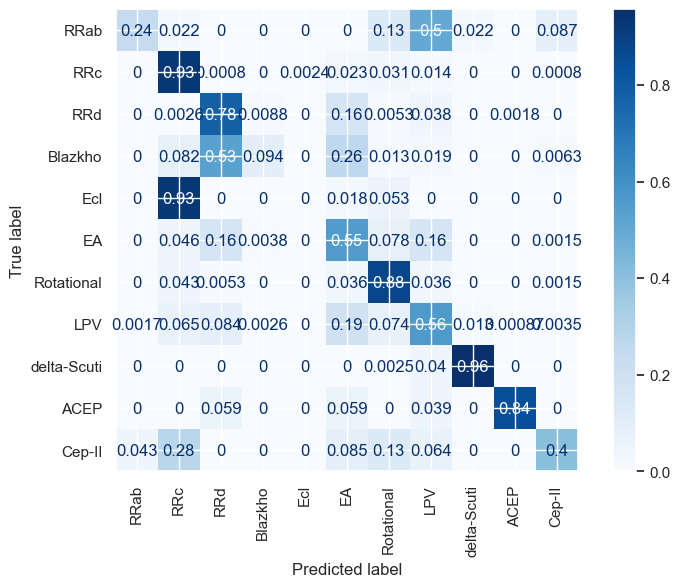

In [147]:
cm = confusion_matrix(yTest, rf_pred, normalize='true')
heatm = ConfusionMatrixDisplay(cm, display_labels=classNames)
heatm.plot(cmap="Blues", xticks_rotation='vertical', values_format ='.2g')

Box and Whisker Plot for Star Types 1 and 6: RRabs and EAs

In [108]:
lTrainBin = largeTrain.query('type in ["1","6"]')
sTrainBin = smallTrain.query('type in ["9", "10"]')

for colL, colS in zip(lTrainBin.columns[2:], sTrainBin.columns[2:]):
    lTrainBin.loc[:, colL] = lTrainBin.loc[:, colL] - lTrainBin[lTrainBin['type'] == '1'].loc[:, colL].median()
    sTrainBin.loc[:, colS] = sTrainBin.loc[:, colS] - sTrainBin[sTrainBin['type'] == '9'].loc[:, colS].median()

C:\Users\nikpr\AppData\Local\Temp\ipykernel_46220\1345728695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lTrainBin.loc[:, colL] = lTrainBin.loc[:, colL] - lTrainBin[lTrainBin['type'] == '1'].loc[:, colL].median()
C:\Users\nikpr\AppData\Local\Temp\ipykernel_46220\1345728695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sTrainBin.loc[:, colS] = sTrainBin.loc[:, colS] - sTrainBin[sTrainBin['type'] == '9'].loc[:, colS].median()
C:\Users\nikpr\AppData\Local\Temp\ipykernel_46220\1345728695.py:5: Set

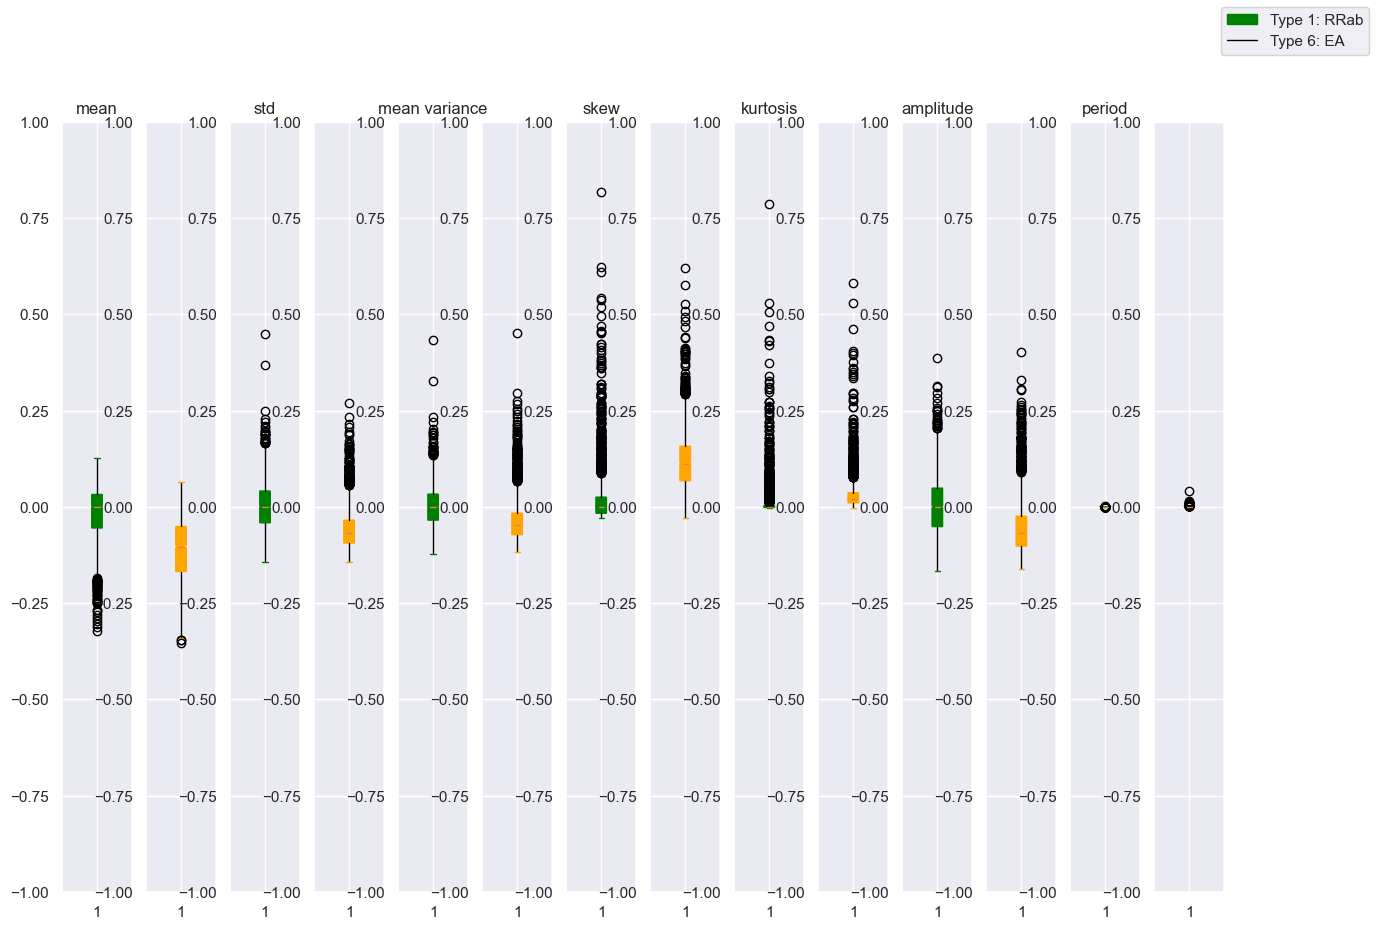

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=2*len(lTrainBin.columns[2:]), figsize=(15,10))
c1, c2 = "green", "orange"
for i,col in enumerate(lTrainBin.columns[2:]):
        ax[i*2].boxplot(lTrainBin.query("type == '1'")[col], notch=True, vert=True, patch_artist=True,
                      boxprops=dict(facecolor=c1, color=c1), capprops=dict(color=c1))
        ax[i*2].set_title(col)
        ax[i*2].set_label("Type 1: RRab")
        ax[i*2].set_ylim(-1,1)
        
for i,col in enumerate(lTrainBin.columns[2:]):
        ax[i*2+1].boxplot(lTrainBin.query("type == '6'")[col], notch=True, vert=True, patch_artist=True,
                boxprops=dict(facecolor=c2, color=c2), capprops=dict(color=c2))
        ax[i*2].set_title(col)
        ax[i*2+1].set_label("Type 6: EA")
        ax[i*2+1].set_ylim(-1,1)
        
fig.legend(["Type 1: RRab", "Type 6: EA"])

Show table 2, with Rpb, MI
Get the JMI rank. JMI(X^k) = I(X^k; Y) - 1/|S| Sum for all j in S(I(X^k; X^j) - I(X^k; X^j|Y))
JMI(X^k) = I(X^k; Y) - 1/|S| Sum for all j in S(I(X^k; X^j) - I(X^k; X^j|Y))

In [110]:
lTrainBin = train.query('type in ["1","6"]')
lTrainBin['type'] = lTrainBin['type'].map({'1':0, '6':1})

C:\Users\nikpr\AppData\Local\Temp\ipykernel_46220\3816344134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lTrainBin['type'] = lTrainBin['type'].map({'1':0, '6':1})


In [111]:
pbCorr = [stats.pointbiserialr(lTrainBin['type'], lTrainBin[col]) for col in lTrainBin.columns[2:]]
Rpb = {col: pbCorr[i].correlation for col, i in zip(lTrainBin.columns[2:], range(7))}

lTrainBin = train.query('type in ["1","6"]')
lTrainBin['type'] = lTrainBin['type'].map({'1':0, '6':1})
pbCorr = [stats.pointbiserialr(lTrainBin['type'], lTrainBin[col]) for col in lTrainBin.columns[2:]]
Rpb = {col: pbCorr[i].correlation for col, i in zip(lTrainBin.columns[2:], range(7))}
mi = mutual_info_classif(lTrainBin[['mean', 'std', 'mean variance', 'skew', 'kurtosis', 'amplitude', 'period']], lTrainBin['type'], random_state=1)
mi.sort()
mi = list(reversed(mi))
mI = {col: m for col,m in zip(lTrainBin.columns[2:], mi)}
tb2 = {"Rpb" : Rpb, "mi" : mI}
Table2 = pd.DataFrame(tb2)
print(f"Table 2:\n {Table2}")    

C:\Users\nikpr\AppData\Local\Temp\ipykernel_46220\2407807904.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lTrainBin['type'] = lTrainBin['type'].map({'1':0, '6':1})


Table 2:
                     Rpb        mi
mean          -0.552171  0.335864
std           -0.469722  0.306272
mean variance -0.352047  0.267088
skew           0.583856  0.199604
kurtosis       0.241811  0.134023
amplitude     -0.365366  0.098962
period         0.393613  0.087934


Table 3 with 5 performance metric results for the 2 sets of two classes (1,6) (9,10)

In [148]:
lTrainBin = largeTrain.query('type in ["1","6"]')
sTrainBin = smallTrain.query('type in ["9", "10"]')
lTestBin = test.query('type in ["1","6"]')
sTestBin = test.query('type in ["9", "10"]')

xTrainBinL, yTrainBinL = lTrainBin.drop(['type', 'Id'], axis=1), lTrainBin['type']
xTrainBinS, yTrainBinS = sTrainBin.drop(['type', 'Id'], axis=1), sTrainBin['type']

xTestBinL, yTestBinL = lTestBin.drop(['type', 'Id'], axis=1), lTestBin['type']
xTestBinS, yTestBinS = sTrainBin.drop(['type', 'Id'], axis=1), sTrainBin['type']


In [149]:
def binaryClassificationPerf(classifier):
    
    lBin = classifier.fit(xTrainBinL, yTrainBinL)
    binLPred = lBin.predict(xTestBinL)
    
    sBin = classifier.fit(xTrainBinS, yTrainBinS)
    binSPred = sBin.predict(xTestBinS)
    cmL, cmS = confusion_matrix(yTestBinL, binLPred), confusion_matrix(yTestBinS, binSPred)
    
    tpL, tnL, fpL, fnL = cmL[0][0], cmL[1][1], cmL[1][0], cmL[0][1]
    tpS, tnS, fpS, fnS = cmS[0][0], cmS[1][1], cmS[1][0], cmS[0][1]

    gMeanL = math.sqrt(tpL*tnL)/math.sqrt((tpL+fnL)*(tnL+fpL))
    gMeanS = math.sqrt(tpS*tnS)/math.sqrt((tpS+fnS)*(tnS+fpS))
    
    precisLC1, precisLC2 = tpL / (tpL+fpL), tnL/(tnL+fnL)
    precisSC1, precisSC2 = tpS / (tpS+fpS), tnS/(tnS+fnS)
    
    recallLC1, recallLC2 = tpL / (tpL+fnL), tnL/(tnL+fpL)
    recallSC1, recallSC2 = tpS / (tpS+fnS), tnS/(tnS+fpS)
    
    f1_L_C1, f1_L_C2 = 2*(precisLC1 * recallLC1)/(precisLC1 + recallLC1), 2*(precisLC2 * recallLC2)/(precisLC2 + recallLC2)
    f1_S_C1, f1_S_C2 = 2*(precisSC1 * recallSC1)/(precisSC1 + recallSC1), 2*(precisSC2 * recallSC2)/(precisSC2 + recallSC2)

    
    accLC1, accSC1 = balanced_accuracy_score(yTestBinL, binLPred), balanced_accuracy_score(yTestBinS, binSPred)
    accLC2, accSC2 = (recallLC1+recallLC2)/2, (recallSC1+recallSC2)/2
    
    new_row_1 = pd.DataFrame({"Classifiers":classifier.__class__.__name__, "Precision":f"{round(precisLC1,3)}/{round(precisLC2,3)}",
                    "Recall":f"{round(recallLC1,3)}/{round(recallLC2,3)}", "F1-score":f"{round(f1_L_C1,3)}/{round(f1_L_C2, 3)}",
                    'G-mean':f"{round(gMeanL,3)}/{round(gMeanL, 3)}", 'Balanced accuracy':f"{round(accLC1,3)}/{round(accLC2,3)}", 'Size':'L'}, index=[0])
    new_row_2 = pd.DataFrame({"Classifiers":classifier.__class__.__name__, "Precision":f"{round(precisSC1,3)}/{round(precisSC2,3)}",
                    "Recall":f"{round(recallSC1,3)}/{round(recallSC2,3)}", "F1-score":f"{round(f1_S_C1,3)}/{round(f1_S_C2, 3)}",
                    'G-mean':f"{round(gMeanS,3)}/{round(gMeanS, 3)}", 'Balanced accuracy':f"{round(accSC1,3)}/{round(accSC2,3)}", 'Size':'S'}, index=[1])
    return (new_row_1, new_row_2)


rfOut = binaryClassificationPerf(rf_clf)
dtOut = binaryClassificationPerf(dt_clf)
knnOut = binaryClassificationPerf(knn_clf)
Table3 = rfOut[0]
Table3 = pd.concat([Table3, dtOut[0], knnOut[0], rfOut[1], dtOut[1], knnOut[1]], ignore_index=True)

Hierarchial Classification:
    split into 3 broad classes, eclipsing, rotational, and pulsating.
    From the top level, we continue to subdivide the classes, for instance, at the third level, we are left with exactly two main classes: RR Lyrae and Cepheids with six science subclasses in the final subnode.

In [152]:
condense_general =  {
    '1':2,'2':2,'3':2,'4':2,'5':0,'6':0,'7':1,'8':2,'9':2,'10':2,'12':2
}
hierLevel1 = train['type'].map(condense_general) #an array of the new types
testHierLevel1 = test['type'].map(condense_general)


condense_pulsating =  {
    '1':0,'2':0,'3':0,'4':0,'8':1,'9':2,'10':3,'12':3
}
pulsating2_1 = train.query('type not in ["7","5","6"]')#remove rotational and eclipsing 
pulsating2_1['type'] = pulsating2_1['type'].map(condense_pulsating)
testPulsating2_1 = test.query('type not in ["7","5","6"]')#remove rotational and eclipsing 
testPulsating2_1['type'] = testPulsating2_1['type'].map(condense_pulsating) # Pulsating, testing set

eclipsing2_2 = train.query('type in ["5","6"]') #Eclipsing
# eclipsing2_2['type'] = eclipsing2_2['type'].map({'5':0,'6':1})
testEclipsing2_2 = test.query('type in ["5","6"]') #Eclipsing, testing
# testEclipsing2_2['type'] = testEclipsing2_2['type'].map({'5':0,'6':1})

RRLyrae3_1 = train.query('type in ["1","2","3","4"]') #RRLyrae
# RRLyrae3_1['type'] = RRLyrae3_1['type'].map({"1":0,"2":1,"3":2,"4":3})
testRRLyrae3_1 = test.query('type in ["1","2","3","4"]') #RRLyrae, testing
# testRRLyrae3_1['type'] = testRRLyrae3_1['type'].map({"1":0,"2":1,"3":2,"4":3})

cephieds3_2 = train.query('type in ["10","12"]') #Cephieds
# cephieds3_2['type'] = cephieds3_2['type'].map({'10':0,'12':1})
testCephieds3_2 = test.query('type in ["10","12"]') #Cephieds, testing
# testCephieds3_2['type'] = testCephieds3_2['type'].map({'10':0,'12':1})

C:\Users\nikpr\AppData\Local\Temp\ipykernel_46220\892603358.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pulsating2_1['type'] = pulsating2_1['type'].map(condense_pulsating)
C:\Users\nikpr\AppData\Local\Temp\ipykernel_46220\892603358.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testPulsating2_1['type'] = testPulsating2_1['type'].map(condense_pulsating) # Pulsating, testing set


In [153]:
level1 = rf_clf.fit(xTrain, hierLevel1)#first level, ternary
l1_Pred = level1.predict(xTest)

level2_1 = rf_clf.fit(pulsating2_1.drop(['type', 'Id'], axis=1), pulsating2_1['type'])#second level 1, quad
l2_1_Pred = level2_1.predict(testPulsating2_1.drop(['type', 'Id'], axis=1))

level2_2 = rf_clf.fit(eclipsing2_2.drop(['type', 'Id'], axis=1), eclipsing2_2['type'])#second level 2, binary
l2_2_Pred = level2_2.predict(testEclipsing2_2.drop(['type', 'Id'], axis=1))

level3_1 = rf_clf.fit(RRLyrae3_1.drop(['type', 'Id'], axis=1), RRLyrae3_1['type'])#third level 1, quad
l3_1_Pred = level3_1.predict(testRRLyrae3_1.drop(['type', 'Id'], axis=1))

level3_2 = rf_clf.fit(cephieds3_2.drop(['type', 'Id'], axis=1), cephieds3_2['type'])#third level 2, binary
l3_2_Pred = level3_2.predict(testCephieds3_2.drop(['type', 'Id'], axis=1))

cmL1 = confusion_matrix(testHierLevel1, l1_Pred)
cmL2_1, cmL2_2 = confusion_matrix(testPulsating2_1['type'], l2_1_Pred), confusion_matrix(testEclipsing2_2['type'], l2_2_Pred)
cmL3_1, cmL3_2 = confusion_matrix(testRRLyrae3_1['type'], l3_1_Pred), confusion_matrix(testCephieds3_2['type'], l3_2_Pred)

#get precision, recall, and f1-score for everything, and the means of those metrics
calcL1 = precision_recall_fscore_support(testHierLevel1, l1_Pred, average=None)
calcL2_1 = precision_recall_fscore_support(testPulsating2_1['type'], l2_1_Pred, average=None)
calcL2_2 = precision_recall_fscore_support(testEclipsing2_2['type'], l2_2_Pred, average=None)
calcL3_1 = precision_recall_fscore_support(testRRLyrae3_1['type'], l3_1_Pred, average=None)
calcL3_2 = precision_recall_fscore_support(testCephieds3_2['type'], l3_2_Pred, average=None)

mCalcL1 = precision_recall_fscore_support(testHierLevel1, l1_Pred, average="macro")
mCalcL2_1 = precision_recall_fscore_support(testPulsating2_1['type'], l2_1_Pred, average="macro")
mCalcL2_2 = precision_recall_fscore_support(testEclipsing2_2['type'], l2_2_Pred, average="macro")
mCalc1L3_1 = precision_recall_fscore_support(testRRLyrae3_1['type'], l3_1_Pred, average="macro")
mCalcL3_2 = precision_recall_fscore_support(testCephieds3_2['type'], l3_2_Pred, average="macro")

#get geometric mean score for everything, and the mean of that metric for each level
gMeanL1 = geometric_mean_score(testHierLevel1, l1_Pred, average=None)
gMeanL2_1 = geometric_mean_score(testPulsating2_1['type'], l2_1_Pred, average=None)
gMeanL2_2 = geometric_mean_score(testEclipsing2_2['type'], l2_2_Pred, average=None)
gMeanL3_1 = geometric_mean_score(testRRLyrae3_1['type'], l3_1_Pred, average=None)
gMeanL3_2 = geometric_mean_score(testCephieds3_2['type'], l3_2_Pred, average=None)

m_gMeanL1 = geometric_mean_score(testHierLevel1, l1_Pred, average="macro")
m_gMeanL2_1 = geometric_mean_score(testPulsating2_1['type'], l2_1_Pred, average="macro")
m_gMeanL2_2 = geometric_mean_score(testEclipsing2_2['type'], l2_2_Pred, average="macro")
m_gMeanL3_1 = geometric_mean_score(testRRLyrae3_1['type'], l3_1_Pred, average="macro")
m_gMeanL3_2 = geometric_mean_score(testCephieds3_2['type'], l3_2_Pred, average="macro")

#get accuracy for everything, and balanced accuracy of each level
accL1 = '/'.join(["{:.3f}".format(cmL1[i][i]/sum(cmL1[i])) for i in range(len(cmL1))])
accL2_1 = '/'.join(["{:.3f}".format(cmL2_1[i][i]/sum(cmL2_1[i])) for i in range(len(cmL2_1))])
accL2_2 = '/'.join(["{:.3f}".format(cmL2_2[i][i]/sum(cmL2_2[i])) for i in range(len(cmL2_2))])
accL3_1 = '/'.join(["{:.3f}".format(cmL3_1[i][i]/sum(cmL3_1[i])) for i in range(len(cmL3_1))])
accL3_2 = '/'.join(["{:.3f}".format(cmL3_2[i][i]/sum(cmL3_2[i])) for i in range(len(cmL3_2))])

balL1 = balanced_accuracy_score(testHierLevel1, l1_Pred)
balL2_1, balL3_1 = balanced_accuracy_score(testPulsating2_1['type'], l2_1_Pred), balanced_accuracy_score(testRRLyrae3_1['type'], l3_1_Pred)
balL2_2, balL3_2 =balanced_accuracy_score(testEclipsing2_2['type'], l2_2_Pred), balanced_accuracy_score(testCephieds3_2['type'], l3_2_Pred)
def convert_f2s(x):
    return "{:.3f}".format(x)

hierRes = {
    "Precision": ['/'.join(map(convert_f2s, calcL1[0])), '/'.join(map(convert_f2s, calcL2_1[0])), '/'.join(map(convert_f2s, calcL2_2[0])), '/'.join(map(convert_f2s, calcL3_1[0])), '/'.join(map(convert_f2s, calcL3_2[0]))],
    "Recall" : ['/'.join(map(convert_f2s, calcL1[1])), '/'.join(map(convert_f2s, calcL2_1[1])), '/'.join(map(convert_f2s, calcL2_2[1])), '/'.join(map(convert_f2s, calcL3_1[1])), '/'.join(map(convert_f2s, calcL3_2[1]))],
    "F1-score": ['/'.join(map(convert_f2s,calcL1[2])), '/'.join(map(convert_f2s,calcL2_1[2])), '/'.join(map(convert_f2s,calcL2_2[2])), '/'.join(map(convert_f2s,calcL3_1[2])), '/'.join(map(convert_f2s,calcL3_2[2]))],
    'G-mean': ['/'.join(map(convert_f2s,gMeanL1)), '/'.join(map(convert_f2s,gMeanL2_1)), '/'.join(map(convert_f2s,gMeanL2_2)), '/'.join(map(convert_f2s,gMeanL3_1)), '/'.join(map(convert_f2s,gMeanL3_2))],
    'Balanced accuracy':[accL1, accL2_1, accL2_2, accL3_1, accL3_2],
    'Class level':[1,2,2,3,3]
}
Table4 = pd.DataFrame(hierRes)